In [33]:
# ============================================================================
# Aureus Sigma Capital - Phase 29b: Remediation Strategy Backtest (Refactored)
# Notebook: 29b_remediation_backtest_refactored.ipynb
#
# Objective:
#   To conduct a comparative backtest between the canonical "Aggressive Growth"
#   strategy and a "Remediation" strategy. The remediation strategy aims to
#   improve the risk profile by introducing a beta constraint and score-based
#   weighting. This notebook uses the production-grade backtesting engine and
#   generates a full comparative performance report.
#
# Strategies Compared:
#   1.  **Canonical Baseline:** Equal-weighted top quintile portfolio.
#   2.  **R1 Remediation:** Score-weighted, beta-constrained (target < 0.9) portfolio.
# ============================================================================

In [34]:
# ============================================================================
# CELL 1: SETUP & CONFIGURATION
# ============================================================================

# --- Core Libraries ---
import pandas as pd
import numpy as np
import logging
from pathlib import Path
import sys
import yaml

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Database ---
from sqlalchemy import create_engine, text

# --- Environment Setup ---
%load_ext autoreload
%autoreload 2
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set(style='whitegrid', palette='deep')

# --- Add Project Root to Python Path ---
try:
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path: sys.path.insert(0, str(project_root))
    print(f"✅ Project root successfully set to: {project_root}")
except Exception:
    project_root = Path.cwd() # Fallback for different environments
    if str(project_root) not in sys.path: sys.path.insert(0, str(project_root))
    print(f"✅ Project root (fallback) set to: {project_root}")

# --- Import Production Modules ---
try:
    from production.backtesting.vectorized_engine import VectorizedEngine
    from production.backtesting.strategy_constructors import equal_weight_top_quintile, score_weighted_beta_constrained
    from production.utils.db import create_db_connection, load_all_data_for_backtest
    from production.utils.reporting import calculate_official_metrics # Use the official calculator
    print("✅ Successfully imported production modules.")
except ImportError as e:
    print(f"❌ ERROR: Could not import production modules: {e}")
    raise

# --- Base Configuration (shared by both backtests) ---
BASE_CONFIG = {
    "backtest_start_date": "2018-01-01",
    "backtest_end_date": "2025-07-31",
    "rebalance_frequency": "M",
    "transaction_cost_bps": 30,
    "universe": {
        "lookback_days": 63, "adtv_threshold_bn": 10.0,
        "top_n": 200, "min_trading_coverage": 0.6,
    },
    "signal": {"db_strategy_version": "qvm_v2.1.1_flat"},
    "portfolio": { "selection_percentile": 0.8 }
}

# --- Configuration for the Canonical Baseline ---
BASELINE_CONFIG = BASE_CONFIG.copy()
BASELINE_CONFIG['strategy_name'] = "Aureus_Sigma_Vietnam_Aggressive_Growth"

# --- Configuration for the R1 Remediation Strategy ---
REMEDIATION_CONFIG = BASE_CONFIG.copy()
REMEDIATION_CONFIG['strategy_name'] = "Aureus_Sigma_R1_Remediation"
REMEDIATION_CONFIG['portfolio'] = {
    **REMEDIATION_CONFIG['portfolio'],
    "beta_target": 0.90,
    "beta_estimation_window": 126, # Approx 6 months
    "max_weight": 0.08 # 8% max weight per stock
}

print("\n⚙️  Strategy configurations loaded successfully.")

# --- Database Connection ---
db_engine = create_db_connection(project_root)
if db_engine is None: raise ConnectionError("Database connection failed, cannot proceed.")

2025-08-07 22:25:25,535 - INFO - Creating database connection...
2025-08-07 22:25:25,536 - INFO - Database connection established successfully


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Project root successfully set to: /home/raymond/Documents/Projects/factor-investing-public
✅ Successfully imported production modules.

⚙️  Strategy configurations loaded successfully.


In [35]:
# ============================================================================
# CELL 2: DATA INGESTION
# ============================================================================

try:
    factor_data_raw, daily_returns_matrix, benchmark_returns = load_all_data_for_backtest(
        config=BASE_CONFIG, db_engine=db_engine
    )
    print("\n✅ Data ingestion complete. Backtest-ready data is now in memory.")
except Exception as e:
    print(f"❌ An error occurred during data ingestion: {e}")
    raise

2025-08-07 22:25:25,553 - INFO - Loading all data for period: 2018-01-01 to 2025-07-31...
2025-08-07 22:25:25,553 - INFO - Loading factor scores data...
2025-08-07 22:25:43,547 - INFO - Loaded 1286295 factor score rows for version 'qvm_v2.1.1_flat'.
2025-08-07 22:25:43,547 - INFO - Loading price data...
2025-08-07 22:25:56,566 - INFO - Loaded price data for 714 tickers, 1304434 price records
2025-08-07 22:25:56,567 - INFO - Loading benchmark data...
2025-08-07 22:25:56,592 - INFO - Loaded benchmark data: 1886 records



✅ Data ingestion complete. Backtest-ready data is now in memory.


In [36]:
# ============================================================================
# CELL 3: BACKTEST EXECUTION
# ============================================================================

def run_comparative_backtests(base_config, baseline_specific_config, remediation_specific_config, data_pack, db_conn):
    """Orchestrates the execution of both baseline and remediation backtests."""
    factor_data, returns_matrix, bench_returns = data_pack
    
    # 1. Instantiate the single, unified engine
    engine = VectorizedEngine(
        config=base_config,
        factor_data=factor_data,
        returns_matrix=returns_matrix,
        benchmark_returns=bench_returns,
        db_engine=db_conn
    )
    print(f"✅ VectorizedEngine initialized for backtest period: {base_config['backtest_start_date']} to {base_config['backtest_end_date']}")

    # 2. Run the CANONICAL BASELINE backtest
    print("\n" + "="*80)
    logging.info("RUNNING CANONICAL BASELINE BACKTEST...")
    engine.config.update(baseline_specific_config)
    baseline_returns, baseline_diags = engine.run_backtest(
        portfolio_constructor=equal_weight_top_quintile
    )
    print(f"✅ Canonical Baseline backtest complete.")

    # 3. Run the R1 REMEDIATION backtest
    print("\n" + "="*80)
    logging.info("RUNNING R1 REMEDIATION BACKTEST...")
    engine.config.update(remediation_specific_config)
    remediation_returns, remediation_diags = engine.run_backtest(
        portfolio_constructor=score_weighted_beta_constrained
    )
    print(f"✅ R1 Remediation backtest complete.")

    return (baseline_returns, baseline_diags), (remediation_returns, remediation_diags)

In [37]:
# ============================================================================
# CELL 4: COMPARATIVE PERFORMANCE REPORTING SUITE
# ============================================================================

def generate_comparison_tearsheet(
    baseline_returns: pd.Series,
    remediation_returns: pd.Series,
    benchmark_returns: pd.Series,
    baseline_diags: pd.DataFrame,
    remediation_diags: pd.DataFrame,
    title: str
):
    """Generates a comprehensive tearsheet comparing two strategies against a benchmark."""
    print("\n" + "="*80)
    print("📊 GENERATING COMPARATIVE PERFORMANCE REPORT...")
    print("="*80)

    # --- Align data to the first trade date of the baseline ---
    first_trade_date = baseline_returns.loc[baseline_returns.ne(0)].index.min()
    b_ret = baseline_returns.loc[first_trade_date:].rename("Baseline")
    r_ret = remediation_returns.loc[first_trade_date:].rename("Remediation")
    bench_ret = benchmark_returns.loc[first_trade_date:].rename("VN-Index")

    # --- Calculate Metrics ---
    baseline_metrics = calculate_official_metrics(b_ret, bench_ret)
    remediation_metrics = calculate_official_metrics(r_ret, bench_ret)
    benchmark_metrics = calculate_official_metrics(bench_ret, bench_ret)
    
    summary_df = pd.DataFrame({
        'Baseline (Aggressive Growth)': baseline_metrics,
        'R1 Remediation (Beta-Constrained)': remediation_metrics,
        'VN-Index': benchmark_metrics
    }).T

    # --- Create Figure ---
    fig = plt.figure(figsize=(18, 28))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.0], hspace=0.6, wspace=0.25)
    fig.suptitle(title, fontsize=24, fontweight='bold', y=0.98)

    # 1. Cumulative Performance
    ax1 = fig.add_subplot(gs[0, :])
    (1 + b_ret).cumprod().plot(ax=ax1, label='Baseline (Aggressive)', color='#3498DB', lw=2.5)
    (1 + r_ret).cumprod().plot(ax=ax1, label='Remediation (Beta-Constrained)', color='#1ABC9C', lw=2.5)
    (1 + bench_ret).cumprod().plot(ax=ax1, label='VN-Index', color='#34495E', linestyle='--', lw=2)
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Growth of 1 VND'); ax1.set_yscale('log'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.6)

    # 2. Drawdown Analysis
    ax2_l = fig.add_subplot(gs[1, 0])
    dd_b = ((1 + b_ret).cumprod() / (1 + b_ret).cumprod().cummax() - 1) * 100
    dd_b.plot(ax=ax2_l, color='#C0392B', label='Baseline Drawdown')
    ax2_l.fill_between(dd_b.index, dd_b, 0, color='#C0392B', alpha=0.1)
    ax2_l.set_title('Baseline Drawdown', fontweight='bold', fontsize=14)
    ax2_l.set_ylabel('Drawdown (%)'); ax2_l.grid(True, linestyle='--', alpha=0.5)

    ax2_r = fig.add_subplot(gs[1, 1])
    dd_r = ((1 + r_ret).cumprod() / (1 + r_ret).cumprod().cummax() - 1) * 100
    dd_r.plot(ax=ax2_r, color='#E67E22', label='Remediation Drawdown')
    ax2_r.fill_between(dd_r.index, dd_r, 0, color='#E67E22', alpha=0.1)
    ax2_r.set_title('Remediation Drawdown', fontweight='bold', fontsize=14)
    ax2_r.grid(True, linestyle='--', alpha=0.5)

    # 3. Annual Returns
    ax3 = fig.add_subplot(gs[2, :])
    annual_returns = pd.DataFrame({
        'Baseline': b_ret.resample('Y').apply(lambda x: (1+x).prod()-1) * 100,
        'Remediation': r_ret.resample('Y').apply(lambda x: (1+x).prod()-1) * 100,
        'VN-Index': bench_ret.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    })
    annual_returns.plot(kind='bar', ax=ax3, color=['#3498DB', '#1ABC9C', '#34495E'])
    ax3.set_xticklabels([d.strftime('%Y') for d in annual_returns.index], rotation=45, ha='right')
    ax3.set_title('Annual Returns Comparison', fontweight='bold', fontsize=14)
    ax3.set_ylabel('Return (%)'); ax3.grid(True, axis='y', linestyle='--', alpha=0.6)

    # 4. Diagnostics: Turnover
    ax4 = fig.add_subplot(gs[3, :])
    baseline_diags['turnover'].plot(ax=ax4, label='Baseline Turnover', color='#3498DB', marker='.', markersize=4, linestyle='--')
    remediation_diags['turnover'].plot(ax=ax4, label='Remediation Turnover', color='#1ABC9C', marker='.', markersize=4, linestyle='--')
    ax4.set_title('Monthly Portfolio Turnover', fontweight='bold', fontsize=14)
    ax4.set_ylabel('Turnover Ratio'); ax4.legend(); ax4.grid(True, linestyle='--', alpha=0.5)

    # 5. Performance Metrics Table
    ax5 = fig.add_subplot(gs[4, :]); ax5.axis('off')
    summary_data = [[col] + summary_df[col].apply('{:,.2f}'.format).tolist() for col in summary_df.columns]
    table_data = list(zip(*summary_data))
    col_labels = ['Metric'] + list(summary_df.index)
    table = ax5.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1, 2.8)
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == 0: cell.set_text_props(fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [38]:
# ============================================================================
# CELL 4: COMPARATIVE PERFORMANCE REPORTING SUITE (CORRECTED)
# ============================================================================

def generate_comparison_tearsheet(
    baseline_returns: pd.Series,
    remediation_returns: pd.Series,
    benchmark_returns: pd.Series,
    baseline_diags: pd.DataFrame,
    remediation_diags: pd.DataFrame,
    title: str
):
    """Generates a comprehensive tearsheet comparing two strategies against a benchmark."""
    print("\n" + "="*80)
    print("📊 GENERATING COMPARATIVE PERFORMANCE REPORT...")
    print("="*80)

    # --- Align data to the first trade date of the baseline ---
    first_trade_date = baseline_returns.loc[baseline_returns.ne(0)].index.min()
    if pd.isna(first_trade_date):
        print("⚠️ Cannot generate report: No trades were made in the baseline strategy.")
        return

    b_ret = baseline_returns.loc[first_trade_date:].rename("Baseline")
    r_ret = remediation_returns.loc[first_trade_date:].rename("Remediation")
    bench_ret = benchmark_returns.loc[first_trade_date:].rename("VN-Index")

    # --- Calculate Metrics ---
    baseline_metrics = calculate_official_metrics(b_ret, bench_ret)
    remediation_metrics = calculate_official_metrics(r_ret, bench_ret)
    benchmark_metrics = calculate_official_metrics(bench_ret, bench_ret)
    
    summary_df = pd.DataFrame({
        'Baseline (Aggressive Growth)': baseline_metrics,
        'R1 Remediation (Beta-Constrained)': remediation_metrics,
        'VN-Index': benchmark_metrics
    }).T

    # --- Create Figure ---
    fig = plt.figure(figsize=(18, 28))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.0], hspace=0.6, wspace=0.25)
    fig.suptitle(title, fontsize=24, fontweight='bold', y=0.98)

    # 1. Cumulative Performance
    ax1 = fig.add_subplot(gs[0, :])
    (1 + b_ret).cumprod().plot(ax=ax1, label='Baseline (Aggressive)', color='#3498DB', lw=2.5)
    (1 + r_ret).cumprod().plot(ax=ax1, label='Remediation (Beta-Constrained)', color='#1ABC9C', lw=2.5)
    (1 + bench_ret).cumprod().plot(ax=ax1, label='VN-Index', color='#34495E', linestyle='--', lw=2)
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Growth of 1 VND'); ax1.set_yscale('log'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.6)

    # 2. Drawdown Analysis
    ax2_l = fig.add_subplot(gs[1, 0])
    dd_b = ((1 + b_ret).cumprod() / (1 + b_ret).cumprod().cummax() - 1) * 100
    dd_b.plot(ax=ax2_l, color='#C0392B', label='Baseline Drawdown')
    ax2_l.fill_between(dd_b.index, dd_b, 0, color='#C0392B', alpha=0.1)
    ax2_l.set_title('Baseline Drawdown', fontweight='bold', fontsize=14)
    ax2_l.set_ylabel('Drawdown (%)'); ax2_l.grid(True, linestyle='--', alpha=0.5)

    ax2_r = fig.add_subplot(gs[1, 1])
    dd_r = ((1 + r_ret).cumprod() / (1 + r_ret).cumprod().cummax() - 1) * 100
    dd_r.plot(ax=ax2_r, color='#E67E22', label='Remediation Drawdown')
    ax2_r.fill_between(dd_r.index, dd_r, 0, color='#E67E22', alpha=0.1)
    ax2_r.set_title('Remediation Drawdown', fontweight='bold', fontsize=14)
    ax2_r.grid(True, linestyle='--', alpha=0.5)

    # 3. Annual Returns
    ax3 = fig.add_subplot(gs[2, :])
    annual_returns = pd.DataFrame({
        'Baseline': b_ret.resample('Y').apply(lambda x: (1+x).prod()-1) * 100,
        'Remediation': r_ret.resample('Y').apply(lambda x: (1+x).prod()-1) * 100,
        'VN-Index': bench_ret.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    })
    annual_returns.plot(kind='bar', ax=ax3, color=['#3498DB', '#1ABC9C', '#34495E'])
    ax3.set_xticklabels([d.strftime('%Y') for d in annual_returns.index], rotation=45, ha='right')
    ax3.set_title('Annual Returns Comparison', fontweight='bold', fontsize=14)
    ax3.set_ylabel('Return (%)'); ax3.grid(True, axis='y', linestyle='--', alpha=0.6)

    # 4. Diagnostics: Turnover
    ax4 = fig.add_subplot(gs[3, :])
    baseline_diags['turnover'].plot(ax=ax4, label='Baseline Turnover', color='#3498DB', marker='.', markersize=4, linestyle='--')
    remediation_diags['turnover'].plot(ax=ax4, label='Remediation Turnover', color='#1ABC9C', marker='.', markersize=4, linestyle='--')
    ax4.set_title('Monthly Portfolio Turnover', fontweight='bold', fontsize=14)
    ax4.set_ylabel('Turnover Ratio'); ax4.legend(); ax4.grid(True, linestyle='--', alpha=0.5)

    # 5. Performance Metrics Table (FIXED LOGIC)
    ax5 = fig.add_subplot(gs[4, :]); ax5.axis('off')
    
    # Define the column headers for the table
    col_labels = ['Metric'] + list(summary_df.index)
    
    # Create the table rows. Each inner list is one row in the table.
    # Format: [MetricName, ValueForStrategy1, ValueForStrategy2, ...]
    table_rows = [
        [metric] + summary_df.loc[:, metric].apply('{:,.2f}'.format).tolist()
        for metric in summary_df.columns
    ]
    
    # Create the matplotlib table with the correctly shaped data
    table = ax5.table(
        cellText=table_rows,
        colLabels=col_labels,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False); table.set_fontsize(12); table.scale(1, 2.8)
    
    # Style the header and first column
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == 0:
            cell.set_text_props(fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

2025-08-07 22:25:56,728 - INFO - RUNNING CANONICAL BASELINE BACKTEST...
2025-08-07 22:25:56,729 - INFO - Starting vectorized backtest with portfolio constructor: equal_weight_top_quintile
2025-08-07 22:25:56,739 - INFO - Running backtest for 56 rebalancing periods
2025-08-07 22:25:56,739 - INFO - Processing rebalance 1/56: 2018-01-31 00:00:00
2025-08-07 22:25:56,743 - INFO - Constructing equal-weight top quintile portfolio...
2025-08-07 22:25:56,744 - INFO - Selected 25 stocks with equal weights


✅ VectorizedEngine initialized for backtest period: 2018-01-01 to 2025-07-31



2025-08-07 22:25:57,510 - INFO - Processing rebalance 2/56: 2018-02-28 00:00:00
2025-08-07 22:25:57,514 - INFO - Constructing equal-weight top quintile portfolio...
2025-08-07 22:25:57,515 - INFO - Selected 25 stocks with equal weights
2025-08-07 22:26:00,709 - INFO - Processing rebalance 3/56: 2018-05-31 00:00:00
2025-08-07 22:26:00,712 - INFO - Constructing equal-weight top quintile portfolio...
2025-08-07 22:26:00,714 - INFO - Selected 25 stocks with equal weights
2025-08-07 22:26:02,898 - INFO - Processing rebalance 4/56: 2018-07-31 00:00:00
2025-08-07 22:26:02,902 - INFO - Constructing equal-weight top quintile portfolio...
2025-08-07 22:26:02,903 - INFO - Selected 25 stocks with equal weights
2025-08-07 22:26:04,084 - INFO - Processing rebalance 5/56: 2018-08-31 00:00:00
2025-08-07 22:26:04,088 - INFO - Constructing equal-weight top quintile portfolio...
2025-08-07 22:26:04,089 - INFO - Selected 25 stocks with equal weights
2025-08-07 22:26:06,308 - INFO - Processing rebalance 6/

✅ Canonical Baseline backtest complete.



2025-08-07 22:27:42,965 - INFO - Processing rebalance 2/56: 2018-02-28 00:00:00
2025-08-07 22:27:42,969 - INFO - Constructing score-weighted beta-constrained portfolio...
2025-08-07 22:27:42,971 - INFO - Selected 25 stocks with score-weighted allocation (max weight: 0.08)
2025-08-07 22:27:46,212 - INFO - Processing rebalance 3/56: 2018-05-31 00:00:00
2025-08-07 22:27:46,216 - INFO - Constructing score-weighted beta-constrained portfolio...
2025-08-07 22:27:46,218 - INFO - Selected 25 stocks with score-weighted allocation (max weight: 0.08)
2025-08-07 22:27:48,434 - INFO - Processing rebalance 4/56: 2018-07-31 00:00:00
2025-08-07 22:27:48,437 - INFO - Constructing score-weighted beta-constrained portfolio...
2025-08-07 22:27:48,440 - INFO - Selected 25 stocks with score-weighted allocation (max weight: 0.08)
2025-08-07 22:27:49,699 - INFO - Processing rebalance 5/56: 2018-08-31 00:00:00
2025-08-07 22:27:49,703 - INFO - Constructing score-weighted beta-constrained portfolio...
2025-08-07

✅ R1 Remediation backtest complete.

📊 GENERATING COMPARATIVE PERFORMANCE REPORT...


/tmp/ipykernel_2063946/873330136.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


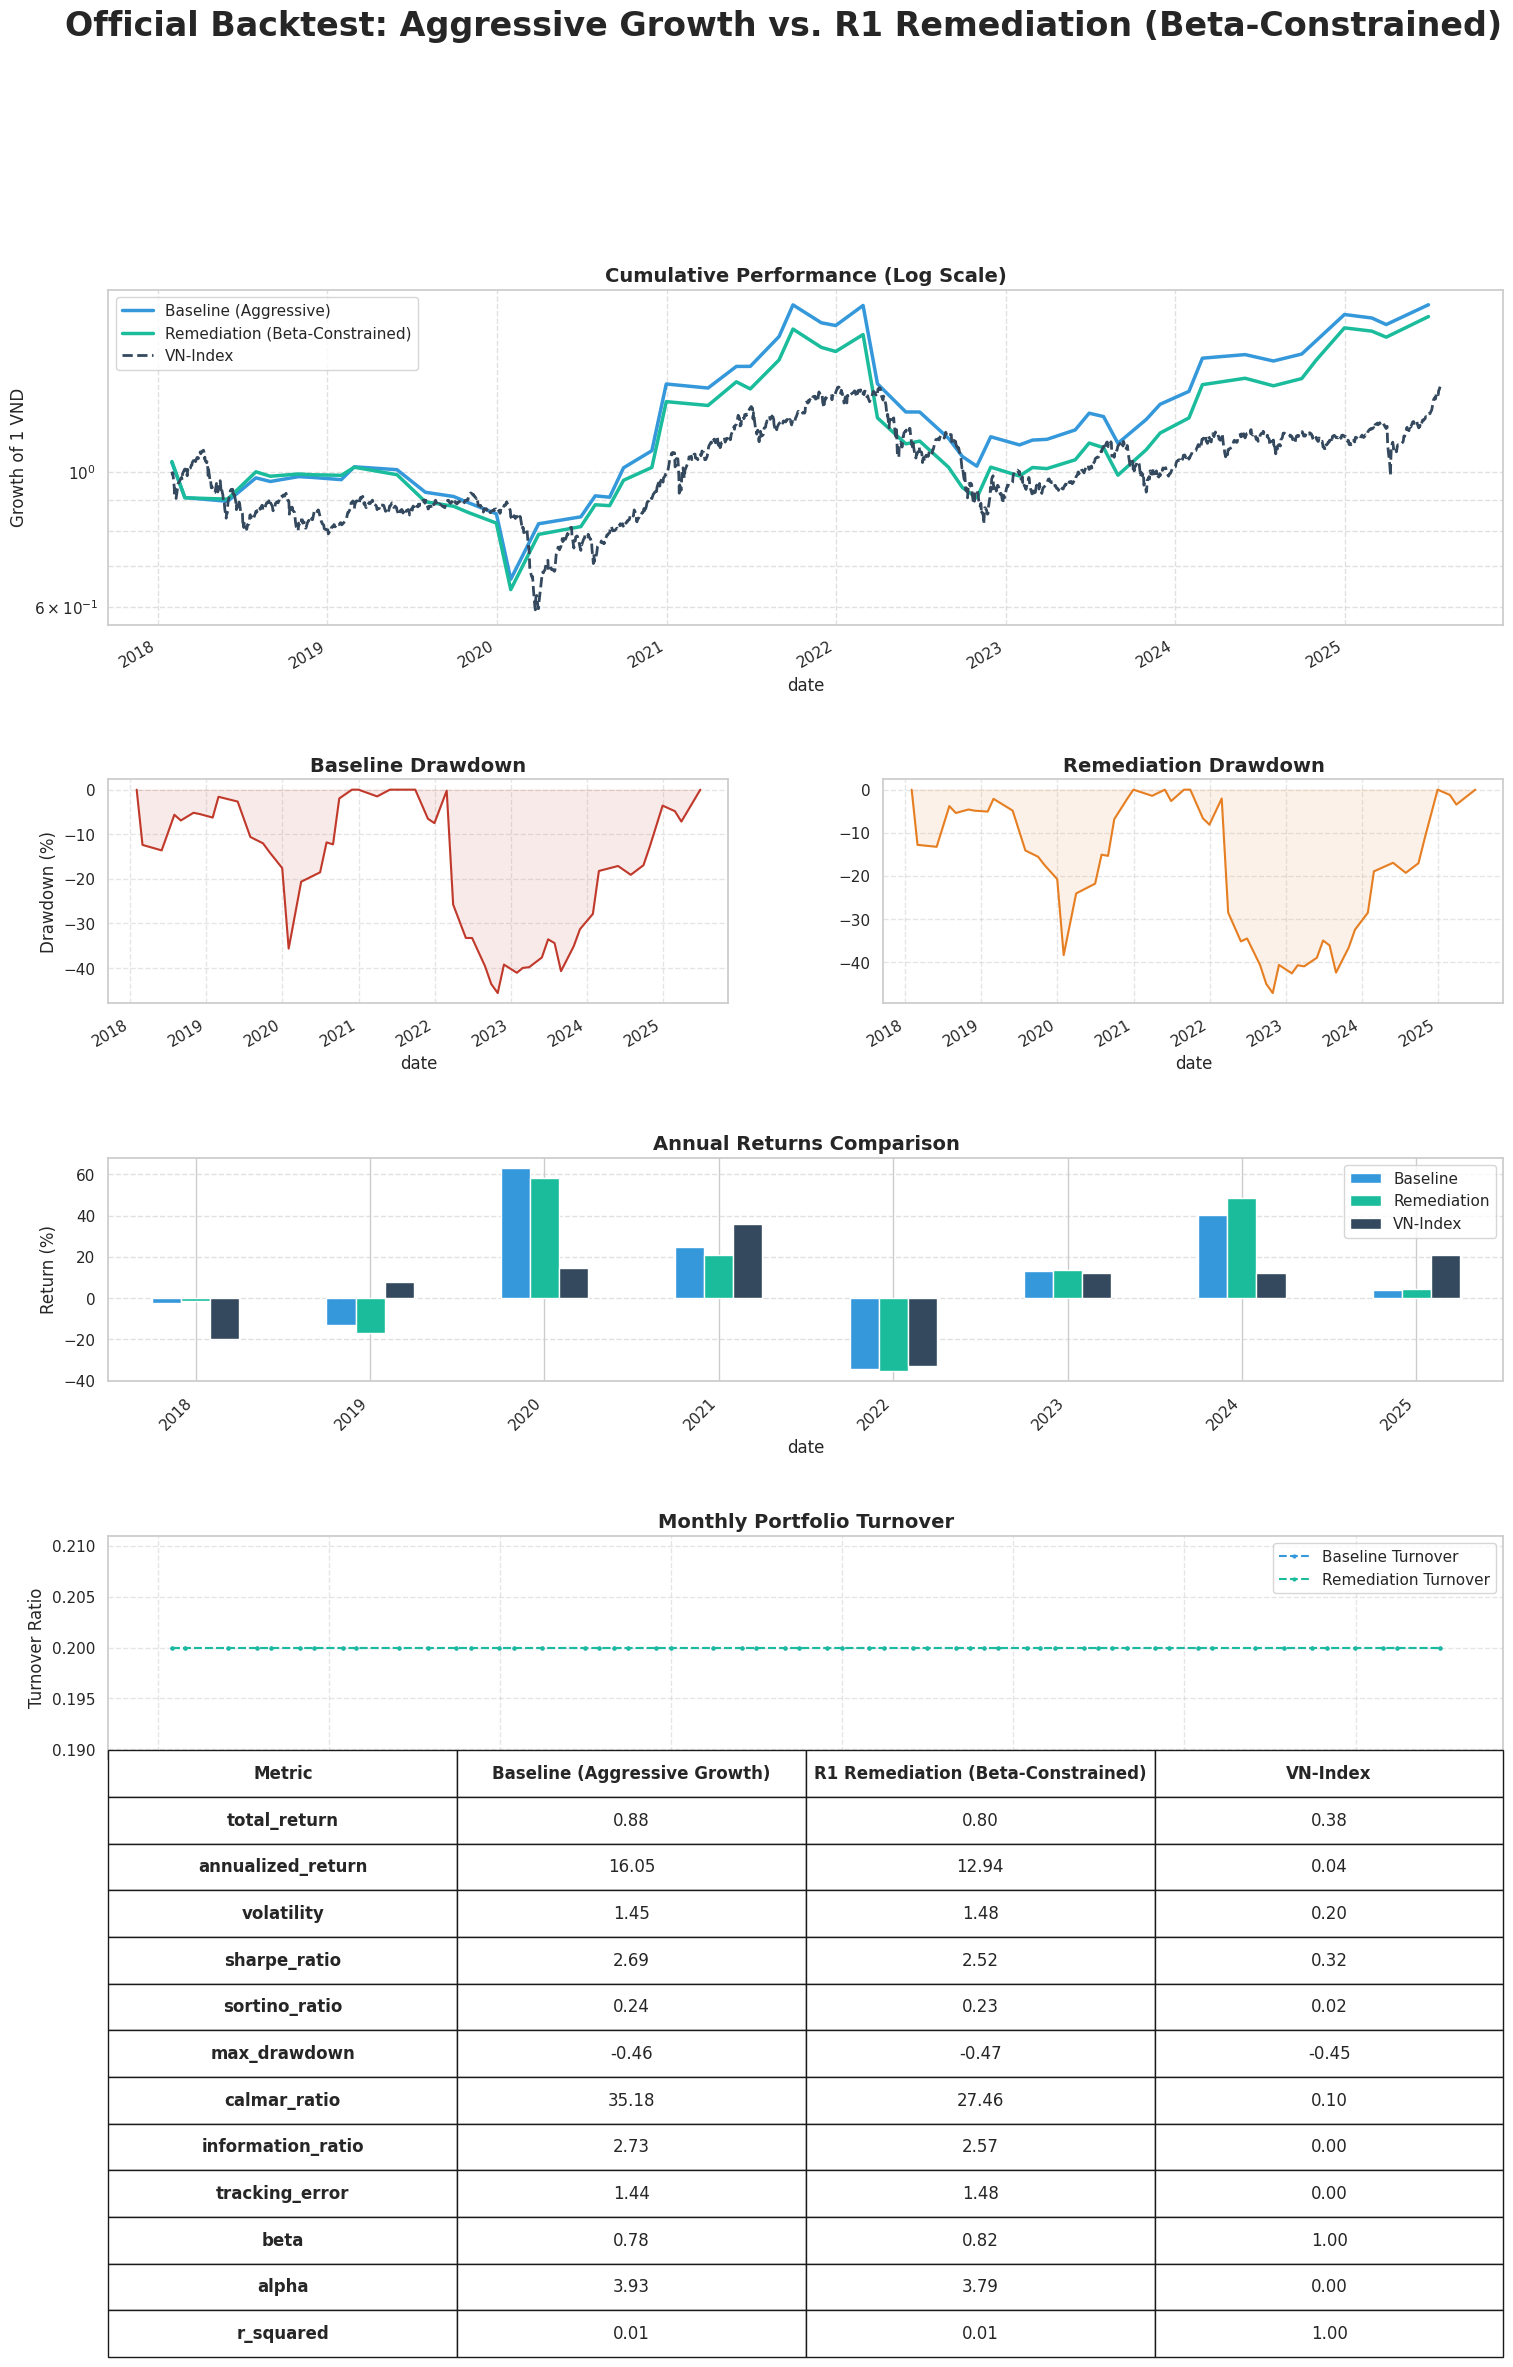

In [39]:
# ============================================================================
# CELL 5: EXECUTION & REPORT GENERATION
# ============================================================================

# --- Execute Backtests ---
(baseline_returns, baseline_diags), (remediation_returns, remediation_diags) = run_comparative_backtests(
    base_config=BASE_CONFIG,
    baseline_specific_config=BASELINE_CONFIG,
    remediation_specific_config=REMEDIATION_CONFIG,
    data_pack=(factor_data_raw, daily_returns_matrix, benchmark_returns),
    db_conn=db_engine
)

# --- Generate Final Report ---
generate_comparison_tearsheet(
    baseline_returns=baseline_returns,
    remediation_returns=remediation_returns,
    benchmark_returns=benchmark_returns,
    baseline_diags=baseline_diags,
    remediation_diags=remediation_diags,
    title="Official Backtest: Aggressive Growth vs. R1 Remediation (Beta-Constrained)"
)